[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1y_VpfrOomKm33b6BxlmeNj09JEbV1b2a)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# ! pip install datasets
# ! pip install gensim 
# ! pip install nltk
# ! pip install tqdm

In [4]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from model_utils import tf, idf, unigram, doc_embed, cluster_docs, wd, opt_svd 
from search_models import Boolean, Vsm, Bim, BimExt, QueryLklhd, W2Vsm, Lsi
from search import searching 
from saveload import indexing
from indices import SubInvertedIndex
from evaluation import MRR

import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

import gensim
import gensim.downloader as api

[nltk_data] Downloading package words to
[nltk_data]     /home/georges_sarr/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/georges_sarr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 5.08 s, sys: 2.9 s, total: 7.98 s
Wall time: 20.5 s


# Indexing the documents collection

In [5]:
%%time
judgments=dict()
inverted_index_sortpost, judgments=indexing(dataset="ms_marco", save=True, save_load_path="./data", index_type='inv', judgments=judgments, version="v1.1", split="test")

.....................Collection indexation in progress.....................


Reusing dataset ms_marco (/home/georges_sarr/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)
100%|██████████| 9650/9650 [00:36<00:00, 264.52it/s]


.....................Successfully saved the index.....................
CPU times: user 38.8 s, sys: 1.24 s, total: 40.1 s
Wall time: 41.4 s


In [6]:
# TAKES TOO MUCH TIME TO RUN >= 10 minutes
# %%time
# positional_index_sortpost=indexing(dataset="ms_marco", save=True, save_load_path="./data", index_type="pos")

# Statistics

In [6]:
print(f"The vocabulary is made of {len(inverted_index_sortpost.index)} words")

The vocabulary is made of 132161 words


### Document lengths

There are 79176 documents


<AxesSubplot:ylabel='Count'>

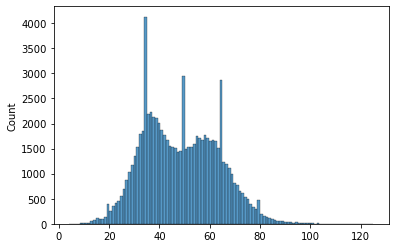

In [7]:
print(f"There are {len(inverted_index_sortpost.documents)} documents")
doc_lenghts=[len(inverted_index_sortpost.raw_freq[ID]) for ID in inverted_index_sortpost.documents]
sb.histplot(doc_lenghts)

In [8]:
round(pd.DataFrame({"doc_lengths": doc_lenghts}).describe(),0)

,doc_lengths
count,79176.0
mean,49.0
std,15.0
min,4.0
25%,37.0
50%,48.0
75%,60.0
max,125.0


### Word raw frequencies

In [9]:
# average number of time each token appears in a document
avg_raw_freqs = [np.mean([inverted_index_sortpost.raw_freq[ID][term] for ID in inverted_index_sortpost.index[term]]) for term in inverted_index_sortpost.index]
round(pd.DataFrame({"avg_raw_freqs":avg_raw_freqs}).describe(),0)

,avg_raw_freqs
count,132161.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,24.0


Most of the terms appear just once in a document.

### Document frequencies

In [10]:
%%time 
doc_freqs=[len(inverted_index_sortpost.index[token]) for token in inverted_index_sortpost.index]
round(pd.DataFrame({"doc_freqs": doc_freqs}).describe(),0)

CPU times: user 94.5 ms, sys: 0 ns, total: 94.5 ms
Wall time: 93.6 ms


,doc_freqs
count,132161.0
mean,29.0
std,571.0
min,1.0
25%,1.0
50%,2.0
75%,5.0
max,73633.0


A term appears on average in 30 $\pm$ 500 documents, 75% of the terms appear in less than 5 documents (a lot of rare terms, weird ??). Lets try to visualize why

In [11]:
for pos , term in enumerate(inverted_index_sortpost.index) : 
    if pos<=500 and len(inverted_index_sortpost.index[term])<=5: print(term) 

stink
relocate
scatter
npr
deters
contributory
fuelsoil
coaltake
circumscribes
apothems
4cm
polygonsproperties
incircle
congruent
equilateral
mathworld
sagitta
weisstein
inradius
hypotenuse


It looks plausible when we look at the above sequence of words (they look rare indeed)

### Relevance judgments

Judgments are used to evaluate models, each query is associated to some relevant documents, and those documents have a relevance score 

In [12]:
[f'{query}: {judgments[query]}' for pos, query in enumerate(judgments) if pos<=2]

['does human hair stop squirrels: {1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1}',
 'what are the benefits of fossil fuels: {8: 1, 9: 2, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1}',
 'what is a apothem: {17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 2, 23: 1, 24: 1, 25: 1}']

In [13]:
print(f"On average {int(np.mean([len(judgments[query]) for query in judgments]))} judgment(s) per query")

On average 8 judgment(s) per query


In [14]:
print(f"The minimum and maximum relevance scores are {min([min(judgments[query].values()) for query in judgments])} and {max([max(judgments[query].values()) for query in judgments])} respectively")

The minimum and maximum relevance scores are 1 and 2 respectively


# Preparing for search

### TF-IDF and language model

In [15]:
tfreqs, idfs, unigram_model=tf(inverted_index_sortpost), idf(inverted_index_sortpost), unigram(inverted_index_sortpost)

100%|██████████| 79176/79176 [00:03<00:00, 20730.25it/s]


### Uploading word2vec model

In [16]:
## Takes up to 10 minutes to run, but TO RUN ONCE !!!
# path = api.load("word2vec-google-news-300", return_path=True)
path="~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
# Takes up to 1 minute to load the google news word2vec model
w2v = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
print(f"Word2Vec model vocabulary size = {len(w2v.key_to_index)} words")

Word2Vec model vocabulary size = 3000000 words


### Document embedding and document clustering

In [17]:
doc2vec=doc_embed(inverted_index_sortpost, tfreqs, idfs, w2v)

100%|██████████| 79176/79176 [00:19<00:00, 4111.19it/s]


Computing K-means model for different values of K


100%|██████████| 2/2 [02:10<00:00, 65.24s/it]


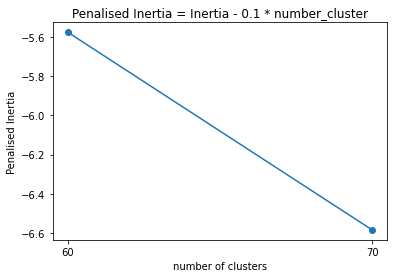

In [18]:
doc_kmeans=cluster_docs(inverted_index_sortpost, doc_embeds=doc2vec,num_min_centr=60,num_max_centr=80,step=10,plot=True)

### Random subsample of the index (for latent semantic indexing (lsi) model)

In [19]:
sub_inv = SubInvertedIndex()
nb_docs=len(inverted_index_sortpost.documents)
nb_sampled_docs=1000
sampled_docs=np.random.choice(a=range(1,nb_docs+1),size=nb_sampled_docs, replace=False)
sub_inv.reindex(inverted_index_sortpost, sampled_docs)

100%|██████████| 1000/1000 [00:00<00:00, 762878.14it/s]


In [20]:
WD, wtoi, dtoi = wd(sub_inv)
WD.shape

1000it [00:00, 16384.06it/s]


(11674, 1000)

Computing SVDs for different values of k


100%|██████████| 9/9 [01:03<00:00,  7.04s/it]


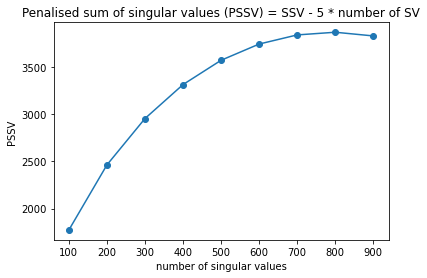

In [21]:
svd_mats=opt_svd(WD,min_k=100,max_k=1000,step_k=100, penalty=5,plot=True)

# Searching

### Simple boolean retrieval

In [22]:
bl=Boolean(index=inverted_index_sortpost, query_type="AND", correct_query=True)
searching(bl)

Did you mean: what is mids ?


Your query:  what is AIDS ?

Result(s): 
What is mean by opportunistic infection-Two examples of opportunistic infections are given below. In day to day life we unknowingly carry out many germs such as, fungi, bacteria, protozoa and viruses. When a person is HIV infection free the immune system resists such invaders. It controls them properly. Examples of Opportunistic Infection. Before going to see the examples of opportunistic infection, it would be better to learn that what is HIV and how it helps such infections to attack on the immune system. HIV is known as Human Immuno Deficiency Virus. The virus leads to develop the AIDS. It attacks on the CD4 cells 

Examples of opportunistic infections are given here for your sake. You can get the list of such examples in the given article. Moreover you would be able to know that what is opportunistic infection and how it leads a person to the life threatening disease that is AIDS. Examples of Opportunistic Infe

## Phrase queries retrieval PENDING( POSITIONAL INDEXING TAKES TIME TO RUN DUE TO PREPROCESSING)

In [37]:
# %%time
# query='''the effects of humidity on the mach number and static pressure in the
# working section were investigated and the results are compared with
# theoretical estimates at a nominal mach number 2.0'''
# phrase_retrieval(positional_index_sortpost, query)

### Vector Space Model

In [23]:
vsm=Vsm(index=inverted_index_sortpost, tfreqs=tfreqs, idfs=idfs, top=5, correct_query=False)
searching(vsm)

Your query:  save the world

Result(s): 
Definition of Green. Living a green lifestyle – or going green – can begin in small, easy to manage ways. Recycling is a huge, obvious part of helping to save the world through green living. Reducing one’s reliance on oil-based energy sources is another popular method employed in trying to save the world. 

Going Green Tips. Some people find that an easy way of going green and helping to save the planet is by creating a compost pile in their backyards. Planting a vegetable garden instead of water hugging grass is another method being used by many people who are trying to save the world. 

In Acrobat Reader DC Save As Save As. To save a copy of a PDF Portfolio Save As Other PDF Portfolio. If you are viewing a PDF in a web browser, the Acrobat File menu is not available. Use the Save A Copy button in the Acrobat toolbar to save the PDF. To the top. 

1 The average monthly fee to Planet Fitness is $15, while the average to other gyms is $50. 2  Thi

In [24]:
bim=Bim(index=inverted_index_sortpost , top=3, correct_query=True)
searching(bim)

Your query:  what is Franc ?

Result(s): 
[fʁɑ̃] ; sign: F or Fr), also commonly distinguished as the French franc (FF), was a currency of France. Between 1360 and 1641, it was the name of coins worth 1 livre tournois and it remained in common parlance as a term for this amount of money. It was reintroduced (in decimal form) in 1795. It was revalued in 1960, with each new franc (NF) being worth 100 old francs. 

By the end of the 20th century, the United States dollar was considered the world's most dominant reserve currency, and the world's need for dollars has allowed the United States government as well as Americans to borrow at lower costs, granting them an advantage in excess of $100 billion per year. The Swiss franc, despite gaining ground among the world's foreign-currency reserves and being often used in denominating foreign loans, cannot be considered as a world reserve currency, since the share of all foreign exchange reserves held in Swiss francs has historically been well b

### Improving with some extensions

In [25]:
two_poisson=BimExt(index=inverted_index_sortpost, extension='two_poisson', top=3)
searching(two_poisson)

Your query:  what is Franc ?

Result(s): 
The currency of France before 2002 was the French Franc. The franc was abolished in 2002 and replaced by the Euro at the rate of €1 = 6.55957 francs. The subdivision of th … e franc was the centime, 1 franc = 100 centimes. The name 'centime' is also used in French for the subdivision of the Euro, €1 = 100 centimes.   France used the franc as its currency up till 2002. Confidence votes 55. The currency used in France is the Euro (symbol €) and its the subdivision is called the 'cent' (English) or 'centime' (French). The Euro replaced the French franc in 2002 at the rate of €1 = 6.55957 francs, and the franc was no longer redeemable after February 201 

French currency conversion. The French Franc is no longer used as money in France, it is now the Euro. The value of the French Franc was fixed at 1 Euro = 6.55957 French Francs, or 1 French Franc = 0.1524490172374104 Euro.  

The franc (₣) is the name of several currency units. The French franc wa

In [26]:
bm11=BimExt(index=inverted_index_sortpost, extension='bm11', top=5, k=1.5)
searching(bm11)

Your query:  what is Franc ?

Result(s): 
The currency of France before 2002 was the French Franc. The franc was abolished in 2002 and replaced by the Euro at the rate of €1 = 6.55957 francs. The subdivision of th … e franc was the centime, 1 franc = 100 centimes. The name 'centime' is also used in French for the subdivision of the Euro, €1 = 100 centimes.   France used the franc as its currency up till 2002. Confidence votes 55. The currency used in France is the Euro (symbol €) and its the subdivision is called the 'cent' (English) or 'centime' (French). The Euro replaced the French franc in 2002 at the rate of €1 = 6.55957 francs, and the franc was no longer redeemable after February 201 

French currency conversion. The French Franc is no longer used as money in France, it is now the Euro. The value of the French Franc was fixed at 1 Euro = 6.55957 French Francs, or 1 French Franc = 0.1524490172374104 Euro.  

The franc (₣) is the name of several currency units. The French franc wa

In [27]:
bm25=BimExt(index=inverted_index_sortpost, extension='bm25', top=5, k=1.5, b=0.8)
searching(bm25)

Your query:  what is Franc ?

Result(s): 
The currency of France before 2002 was the French Franc. The franc was abolished in 2002 and replaced by the Euro at the rate of €1 = 6.55957 francs. The subdivision of th … e franc was the centime, 1 franc = 100 centimes. The name 'centime' is also used in French for the subdivision of the Euro, €1 = 100 centimes.   France used the franc as its currency up till 2002. Confidence votes 55. The currency used in France is the Euro (symbol €) and its the subdivision is called the 'cent' (English) or 'centime' (French). The Euro replaced the French franc in 2002 at the rate of €1 = 6.55957 francs, and the franc was no longer redeemable after February 201 

French currency conversion. The French Franc is no longer used as money in France, it is now the Euro. The value of the French Franc was fixed at 1 Euro = 6.55957 French Francs, or 1 French Franc = 0.1524490172374104 Euro.  

The franc (₣) is the name of several currency units. The French franc wa

### Language model

In [28]:
ql=QueryLklhd(index=inverted_index_sortpost, lang_model=unigram_model, top=3, correct_query=True)
searching(ql)

Did you mean: eave the world ?


Your query:  Save the world ?!

Result(s): 
The shorter the pushrod side of the rocker arm and the longer the valve side of the rocker arm, the higher the lift ratio of the rocker. If the length of the valve side of the rocker is 1.5 times that of the pushrod side, the lift ratio will be 1.5:1.  

Remove the Transmission from the Vehicle. Place a transmission jack underneath the transmission. Raise the jack until it is supporting the weight of the transmission. Remove the bolts that connect the engine to the transmission. Remove the bolts that secure the transmission to the engine. Remove the bolts that secure the transmission to the transmission crossmember. Remove the bolts that connect the transmission crossmember to the vehicle's frame. Remove the transmission crossmember from the vehicle. Slide the transmission rearward until the front of the transmission housing disengages from the locating pins on the engine block 

The vertebral border of the sc

### Word2Vec Vector Space model

In [29]:
# Not clustering the documents before hand takes up to 10 seconds
w2vvsm_np=W2Vsm(index=inverted_index_sortpost, idfs=idfs, word_embeds=w2v, doc_embeds=doc2vec, precluster=False)
searching(w2vvsm_np)

100%|██████████| 79176/79176 [00:09<00:00, 7935.83it/s]


Your query:  what is AIDS ?

Result(s): 
Physical therapist assistants (PTAs) work as part of a dynamic healthcare team. Assistants help physical therapists maintain therapy facilities and monitor patient progress, while also helping patients by assisting them on difficult movements and instructing them on how to use walking aids.  

Biofeedback sessions are typically done in a therapist's office, but there are computer programs that connect the biofeedback sensor to your own computer. A biofeedback therapist helps you practice relaxation exercises, which you fine-tune to control different body functions. Researchers aren't exactly sure how or why biofeedback works. They do know that biofeedback promotes relaxation, which can help relieve a number of conditions that are related to stress. During a biofeedback session, electrodes are attached to your skin. Finger sensors can also be used. These electrodes/sensors send signals to a monitor, which displays a sound, flash of light, or imag

In [30]:
w2vvsm_p=W2Vsm(index=inverted_index_sortpost, idfs=idfs, word_embeds=w2v, doc_embeds=doc2vec, precluster=True,
               cluster_centers=doc_kmeans.cluster_centers_, doc_cluster_labels=doc_kmeans.labels_, top_center=10)
searching(w2vvsm_p)

Your query:  what is AIDS ?

Result(s): 
Physical therapist assistants (PTAs) work as part of a dynamic healthcare team. Assistants help physical therapists maintain therapy facilities and monitor patient progress, while also helping patients by assisting them on difficult movements and instructing them on how to use walking aids.  

Biofeedback sessions are typically done in a therapist's office, but there are computer programs that connect the biofeedback sensor to your own computer. A biofeedback therapist helps you practice relaxation exercises, which you fine-tune to control different body functions. Researchers aren't exactly sure how or why biofeedback works. They do know that biofeedback promotes relaxation, which can help relieve a number of conditions that are related to stress. During a biofeedback session, electrodes are attached to your skin. Finger sensors can also be used. These electrodes/sensors send signals to a monitor, which displays a sound, flash of light, or imag

### Latent semantic indexing

In [31]:
lsi=Lsi(index=sub_inv, idfs=idfs, top=3, svd_word_doc_mat=svd_mats, dtoi=dtoi, wtoi=wtoi)
searching(lsi)

Your query:  text message

Result(s): 
Becky is generally used as a girl's name. It consists of 5 letters and 2 syllables and is pronounced Bec-ky. In the U.S. in 2014, it ranked 3095 in baby name popularity for girls with 53 occurrences. Less than 5 boys were given the name. View the Becky Name Popularity Page to see how the popularity trend for Becky has changed since 1880, or to compare the popularity of Becky to other names. Becky is a diminutive (nickname) of Rebecca. Then just follow the diagram below. Just for fun, see the name Becky in Hieroglyphics, learn about ancient Egyptian Hieroglyphics and write a Hieroglyphic message. Learn about nautical flags and see your name or message written in nautical flags, on the Becky in Nautical Flags page. 

Sponsorship Basics. When advertising agencies and media refer to sponsors, they are typically talking about the company or organization that pays to buy media space. Thus, the general use of sponsorship is in reference to the paid spons

# Evaluation

In [32]:
[f'{query}: {judgments[query]}' for pos, query in enumerate(judgments) if pos<=2]

['does human hair stop squirrels: {1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1}',
 'what are the benefits of fossil fuels: {8: 1, 9: 2, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1}',
 'what is a apothem: {17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 2, 23: 1, 24: 1, 25: 1}']

In [55]:
bim2=Bim(index=inverted_index_sortpost , top=3, correct_query=False)
MRR(bim2, {query: rel for pos, (query, rel) in enumerate(judgments.items()) if pos<=100}, at_K=5)

100%|██████████| 101/101 [00:17<00:00,  5.90it/s]


0.2356435643564356

In [53]:
bm25_2=BimExt(index=inverted_index_sortpost, extension='bm25', k=1.5, b=0.75)
MRR(bm25_2, {query: rel for pos, (query, rel) in enumerate(judgments.items()) if pos<=100}, at_K=10)

100%|██████████| 101/101 [00:44<00:00,  2.27it/s]


0.34069621247839077